# Importing libraries

In [39]:
import numpy as np
import pandas as pd

In [40]:
!pip install -q scikit-learn==1.3.2 imbalanced-learn==0.11.0

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import xgboost as xgb
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [43]:
RANDOM_STATE = 5
np.random.seed(RANDOM_STATE)

# Exploring the dataset

In [44]:
df = pd.read_csv("/kaggle/input/psb-hackathon-2025/HACKATHON_TRAINING_DATA.CSV")

In [45]:
def explore_data(df):
    """Initial data exploration"""
    print(f"Dataset shape: {df.shape}")
    print(f"\nTarget distribution:")
    print(df['TARGET'].value_counts())
    print(f"Fraud rate: {df['TARGET'].mean():.2%}")
    
    print(f"\nMissing values:")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    print(f"\nData types:")
    print(df.dtypes.value_counts())
    
    return df

# Feature engineering

In [46]:
def create_features(df):
    """Advanced feature engineering for fraud detection"""
    print("\n=====================Creating new features=====================")
    
    df_feat = df.copy()
    
    # -------------------------------------------------------------------------
    # 1. TEMPORAL PATTERN FEATURES (Monthly transaction analysis)
    # -------------------------------------------------------------------------
    
    # Credit amounts for each month
    credit_cols = [f'{num}MNTHCR' for num in ['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX', 
                                              'SEVEN', 'EIGHT', 'NINE', 'TEN', 'ELEVEN', 'TWELVE']]
    
    # Debit amounts for each month  
    debit_cols = [f'{num}MNTHSDR' for num in ['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX',
                                              'SEVEN', 'EIGHT', 'NINE', 'TEN', 'ELEVEN', 'TWELVE']]
    
    # Outstanding balance for each month
    balance_cols = [f'{num}MNTHOUTSTANGBAL' for num in ['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX',
                                                        'SEVEN', 'EIGHT', 'NINE', 'TEN', 'ELEVEN', 'TWELVE']]
    
    # Create temporal features
    for cols in [credit_cols, debit_cols, balance_cols]:
        available_cols = [col for col in cols if col in df_feat.columns]
        if available_cols:
            # Monthly statistics
            df_feat[f'mean_{available_cols[0].split("MNTH")[1]}'] = df_feat[available_cols].mean(axis=1)
            df_feat[f'std_{available_cols[0].split("MNTH")[1]}'] = df_feat[available_cols].std(axis=1)
            df_feat[f'max_{available_cols[0].split("MNTH")[1]}'] = df_feat[available_cols].max(axis=1)
            df_feat[f'min_{available_cols[0].split("MNTH")[1]}'] = df_feat[available_cols].min(axis=1)
            
            # Trend analysis (recent vs older months)
            if len(available_cols) >= 6:
                recent = df_feat[available_cols[:3]].mean(axis=1)
                older = df_feat[available_cols[-3:]].mean(axis=1)
                df_feat[f'trend_{available_cols[0].split("MNTH")[1]}'] = recent - older
    
    # -------------------------------------------------------------------------
    # 2. RISK AGGREGATION FEATURES
    # -------------------------------------------------------------------------
    
    # Combined risk score
    risk_features = ['KYC_SCR']
    if all(col in df_feat.columns for col in risk_features):
        df_feat['combined_risk_score'] = df_feat[risk_features].mean(axis=1)
    
    # NPA risk indicators
    npa_cols = [col for col in df_feat.columns if 'NPA' in col]
    if npa_cols:
        df_feat['npa_risk_score'] = df_feat[npa_cols].fillna(0).sum(axis=1)
    
    # RG (Risk Grade) aggregation
    rg_cols = [col for col in df_feat.columns if col.startswith('LAST_') and 'RG' in col]
    if rg_cols:
        df_feat['total_rg_risk'] = df_feat[rg_cols].fillna(0).sum(axis=1)
    
    # -------------------------------------------------------------------------
    # 3. ACCOUNT BEHAVIOR FEATURES
    # -------------------------------------------------------------------------
    
    # Account utilization
    if 'LIMIT' in df_feat.columns and 'OUTS' in df_feat.columns:
        df_feat['utilization_ratio'] = df_feat['OUTS'] / (df_feat['LIMIT'] + 1e-8)
        df_feat['available_credit'] = df_feat['LIMIT'] - df_feat['OUTS']
    
    # Age-based features
    if 'ACCT_AGE' in df_feat.columns and 'AGE' in df_feat.columns:
        df_feat['account_age_ratio'] = df_feat['ACCT_AGE'] / (df_feat['AGE'] + 1e-8)
    
    # Loan characteristics
    if 'NO_LONS' in df_feat.columns and 'ALL_LON_LIMIT' in df_feat.columns:
        df_feat['avg_loan_limit'] = df_feat['ALL_LON_LIMIT'] / (df_feat['NO_LONS'] + 1e-8)
        df_feat['loan_to_account_age'] = df_feat['NO_LONS'] / (df_feat['ACCT_AGE'] + 1e-8)
    
    # -------------------------------------------------------------------------
    # 4. ANOMALY INDICATORS
    # -------------------------------------------------------------------------
    
    # Flag sudden changes in behavior
    monthly_cols = [col for col in df_feat.columns if 'MNTH' in col and 'CR' in col]
    if len(monthly_cols) >= 3:
        # Recent activity spike
        recent_avg = df_feat[monthly_cols[:3]].mean(axis=1)
        historical_avg = df_feat[monthly_cols[3:]].mean(axis=1)
        df_feat['activity_spike'] = (recent_avg > historical_avg * 2).astype(int)
    
    # -------------------------------------------------------------------------
    # 5. CATEGORICAL ENCODING
    # -------------------------------------------------------------------------
    
    # Handle categorical variables
    categorical_cols = df_feat.select_dtypes(include=['object']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in ['TARGET', 'UNIQUE_ID']]
    
    for col in categorical_cols:
        if df_feat[col].nunique() < 50:  # Only encode if reasonable number of categories
            le = LabelEncoder()
            df_feat[f'{col}_encoded'] = le.fit_transform(df_feat[col].astype(str))
    
    print(f"Features created. New shape: {df_feat.shape}")
    return df_feat

# Data Pre-processing

In [69]:
def preprocess_data(df):
    """Clean and prepare banking data with comprehensive imputation and encoding"""
    print("\n=====================Preprocessing data with banking domain logic=====================")
    
    df_clean = df.copy()
    original_shape = df_clean.shape
    
    # -------------------------------------------------------------------------
    # 1. IDENTIFY COLUMN TYPES
    # -------------------------------------------------------------------------
    
    # Separate numeric and categorical columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Remove target and ID columns from processing
    exclude_cols = ['TARGET', 'UNIQUE_ID', 'TIME_PERIOD']
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    categorical_cols = [col for col in categorical_cols if col not in exclude_cols]
    
    print(f"Found {len(numeric_cols)} numeric and {len(categorical_cols)} categorical columns")
    
    # -------------------------------------------------------------------------
    # 2. HANDLE CATEGORICAL VARIABLES FIRST
    # -------------------------------------------------------------------------
    
    print("Processing categorical variables...")
    
    for col in categorical_cols:
        print(f"Processing categorical column: {col}")
        
        # Handle missing values in categorical columns
        if df_clean[col].isnull().sum() > 0:
            # For banking data, missing categorical often means "Unknown" or "Not Available"
            df_clean[col] = df_clean[col].fillna('MISSING')
            print(f"  Filled {df_clean[col].isnull().sum()} missing values with 'MISSING'")
        
        # Convert to string to handle mixed types
        df_clean[col] = df_clean[col].astype(str)
        
        # Check number of unique values
        n_unique = df_clean[col].nunique()
        print(f"  Unique values: {n_unique}")
        
        if n_unique <= 50:  # Reasonable number for encoding
            # Label Encoding for ordinal-like variables or low cardinality
            if any(keyword in col.upper() for keyword in ['GRADE', 'BAND', 'CODE', 'TYPE', 'FLG', 'IND']):
                le = LabelEncoder()
                df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col])
                print(f"  Applied Label Encoding -> {col}_encoded")
            else:
                # One-hot encoding for nominal variables with low cardinality
                if n_unique <= 10:
                    dummies = pd.get_dummies(df_clean[col], prefix=col, drop_first=True)
                    df_clean = pd.concat([df_clean, dummies], axis=1)
                    print(f"  Applied One-Hot Encoding -> {len(dummies.columns)} new columns")
                else:
                    # Label encoding for higher cardinality
                    le = LabelEncoder()
                    df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col])
                    print(f"  Applied Label Encoding (high cardinality) -> {col}_encoded")
        else:
            # For very high cardinality, use frequency encoding
            freq_encoding = df_clean[col].value_counts().to_dict()
            df_clean[f'{col}_freq_encoded'] = df_clean[col].map(freq_encoding)
            print(f"  Applied Frequency Encoding -> {col}_freq_encoded")
        
        # Keep original for reference but will remove later
        original_categorical_cols = categorical_cols.copy()
    
    # -------------------------------------------------------------------------
    # 3. COMPREHENSIVE NUMERIC IMPUTATION
    # -------------------------------------------------------------------------
    
    print("Processing numeric variables with domain-specific logic...")
    
    # Create missingness indicators BEFORE imputation
    print("Creating missingness indicators...")
    important_cols_for_missing = ['KYC_SCR', 'NO_ENQ', 'FIRST_NPA_TENURE', 'INCOME_BAND1', 
                                  'LIMIT', 'OUTS', 'AGE', 'VINTAGE']
    
    for col in important_cols_for_missing:
        if col in df_clean.columns:
            missing_col_name = f'{col}_was_missing'
            df_clean[missing_col_name] = df_clean[col].isnull().astype(int)
            print(f"  Created missingness indicator: {missing_col_name}")
    
    # 1. ACCOUNT & DEMOGRAPHIC FEATURES
    demographic_cols = ['ACCT_AGE', 'AGE', 'VINTAGE', 'KYC_SCR', 'ACCT_RESIDUAL_TENURE']
    for col in demographic_cols:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"  Filled {col} with median: {median_val}")
    
    # 2. FINANCIAL LIMITS & AMOUNTS
    financial_zero_cols = ['LIMIT', 'OUTS', 'INSTALAMT', 'ALL_LON_LIMIT', 'ALL_LON_OUTS']
    for col in financial_zero_cols:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna(0)
            print(f"  Filled {col} with 0 (no limit/amount)")
    
    # 3. MONTHLY TRANSACTION DATA
    monthly_pattern_cols = [col for col in df_clean.columns if 'MNTH' in col and 
                           any(x in col for x in ['CR', 'SDR', 'BAL', 'AVG'])]
    for col in monthly_pattern_cols:
        if df_clean[col].isnull().sum() > 0:
            # Fill with 0 for transaction data (no activity)
            df_clean[col] = df_clean[col].fillna(0)
            print(f"  Filled {col} with 0 (no transaction)")
    
    # 4. COUNT VARIABLES
    count_cols = ['NO_LONS', 'NO_ENQ', 'CUST_NO_OF_TIMES_NPA', 'NO_OF_INQUIRIES1', 
                  'PRI_NO_OF_ACCTS1', 'PRI_ACTIVE_ACCTS1', 'PRI_OVERDUE_ACCTS1', 
                  'NEW_ACCTS_IN_LAST_SIX_MONTHS1', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS1']
    for col in count_cols:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna(0)
            print(f"  Filled {col} with 0 (no count)")
    
    # 5. TENURE/TIME VARIABLES with group-wise logic
    tenure_cols = [col for col in df_clean.columns if 'TENURE' in col or 'DAYS' in col]
    for col in tenure_cols:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            # Try group-wise filling first
            if 'PRODUCT_TYPE_encoded' in df_clean.columns:
                df_clean[col] = df_clean.groupby('PRODUCT_TYPE_encoded')[col].transform(
                    lambda x: x.fillna(x.median()) if x.median() == x.median() else x.fillna(0)
                )
            # Fill remaining with overall median or 0
            remaining_missing = df_clean[col].isnull().sum()
            if remaining_missing > 0:
                fill_val = df_clean[col].median() if df_clean[col].median() == df_clean[col].median() else 0
                df_clean[col] = df_clean[col].fillna(fill_val)
                print(f"  Filled {col} with group-wise logic, remaining filled with {fill_val}")
    
    # 6. RISK GRADES AND SCORES
    risk_grade_cols = [col for col in df_clean.columns if 
                      (col.startswith('LAST_') and 'RG' in col) or 'IRAC' in col]
    for col in risk_grade_cols:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            # Use mode for risk grades, median for continuous scores
            if any(x in col for x in ['RG1', 'RG2', 'RG3', 'RG4']):
                mode_val = df_clean[col].mode().iloc[0] if not df_clean[col].mode().empty else 0
                df_clean[col] = df_clean[col].fillna(mode_val)
                print(f"  Filled {col} with mode: {mode_val}")
            else:
                median_val = df_clean[col].median() if df_clean[col].median() == df_clean[col].median() else 0
                df_clean[col] = df_clean[col].fillna(median_val)
                print(f"  Filled {col} with median: {median_val}")
    
    # 7. CRIFF AND CREDIT BUREAU SCORES
    criff_cols = [col for col in df_clean.columns if 'CRIFF' in col or 'CREDIT' in col]
    for col in criff_cols:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            # Group by income band if available
            if 'INCOME_BAND1_encoded' in df_clean.columns:
                df_clean[col] = df_clean.groupby('INCOME_BAND1_encoded')[col].transform(
                    lambda x: x.fillna(x.median()) if x.median() == x.median() else x.fillna(0)
                )
            # Fill remaining
            remaining_missing = df_clean[col].isnull().sum()
            if remaining_missing > 0:
                fill_val = df_clean[col].median() if df_clean[col].median() == df_clean[col].median() else 0
                df_clean[col] = df_clean[col].fillna(fill_val)
                print(f"  Filled {col} with income-group logic")
    
    # 8. BALANCE/AMOUNT FIELDS
    balance_amount_cols = [col for col in df_clean.columns if 
                          any(x in col.upper() for x in ['BALANCE', 'AMOUNT', 'SANCTIONED', 'DISBURSED'])]
    for col in balance_amount_cols:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna(0)
            print(f"  Filled {col} with 0 (no balance/amount)")
    
    # 9. AGGRESSIVE CATCH-ALL for any remaining missing values
    print("Final sweep for any remaining missing values...")
    for col in df_clean.columns:
        if df_clean[col].dtype in ['int64', 'float64'] and df_clean[col].isnull().sum() > 0:
            # Try median first, then 0 if median is NaN
            median_val = df_clean[col].median()
            fill_val = median_val if median_val == median_val else 0
            missing_count = df_clean[col].isnull().sum()
            df_clean[col] = df_clean[col].fillna(fill_val)
            print(f"  Final fill for {col}: {missing_count} values filled with {fill_val}")
    
    # -------------------------------------------------------------------------
    # 4. HANDLE INFINITE VALUES
    # -------------------------------------------------------------------------
    
    print("Handling infinite values...")
    for col in df_clean.select_dtypes(include=[np.number]).columns:
        if col in exclude_cols:
            continue
            
        # Check for infinite values
        inf_count = np.isinf(df_clean[col]).sum()
        if inf_count > 0:
            print(f"  Handling {inf_count} infinite values in {col}")
            
            # Get finite values for percentile calculation
            finite_values = df_clean[col][np.isfinite(df_clean[col])]
            
            if len(finite_values) > 0:
                # Replace +inf with 99.9th percentile
                pos_inf_mask = np.isposinf(df_clean[col])
                if pos_inf_mask.sum() > 0:
                    replacement_val = finite_values.quantile(0.999)
                    df_clean.loc[pos_inf_mask, col] = replacement_val
                
                # Replace -inf with 0.1th percentile
                neg_inf_mask = np.isneginf(df_clean[col])
                if neg_inf_mask.sum() > 0:
                    replacement_val = finite_values.quantile(0.001)
                    df_clean.loc[neg_inf_mask, col] = replacement_val
            else:
                # If no finite values, replace all inf with 0
                df_clean[col] = df_clean[col].replace([np.inf, -np.inf], 0)
    
    # -------------------------------------------------------------------------
    # 5. REMOVE ORIGINAL CATEGORICAL COLUMNS (keep encoded versions)
    # -------------------------------------------------------------------------
    
    print("Cleaning up original categorical columns...")
    cols_to_drop = [col for col in original_categorical_cols if col in df_clean.columns]
    if cols_to_drop:
        df_clean = df_clean.drop(columns=cols_to_drop)
        print(f"  Dropped original categorical columns: {len(cols_to_drop)} columns")
    
    # -------------------------------------------------------------------------
    # 6. FINAL VALIDATION
    # -------------------------------------------------------------------------
    
    print("Final data validation...")
    
    # Check for any remaining missing values
    total_missing = df_clean.isnull().sum().sum()
    if total_missing > 0:
        print(f"WARNING: Still have {total_missing} missing values!")
        remaining_missing = df_clean.isnull().sum()
        print("Columns with missing values:")
        for col, count in remaining_missing[remaining_missing > 0].items():
            print(f"  {col}: {count} missing")
        
        # Force fill any remaining with 0
        df_clean = df_clean.fillna(0)
        print("Force-filled all remaining missing values with 0")
    
    # Check for infinite values
    inf_cols = []
    for col in df_clean.select_dtypes(include=[np.number]).columns:
        if np.isinf(df_clean[col]).sum() > 0:
            inf_cols.append(col)
    
    if inf_cols:
        print(f"WARNING: Still have infinite values in: {inf_cols}")
        df_clean = df_clean.replace([np.inf, -np.inf], 0)
        print("Force-replaced all infinite values with 0")
    
    print(f"\nData preprocessing completed!")
    print(f"Original shape: {original_shape}")
    print(f"Final shape: {df_clean.shape}")
    print(f"Missing values: {df_clean.isnull().sum().sum()}")
    print(f"Infinite values: {np.isinf(df_clean.select_dtypes(include=[np.number])).sum().sum()}")
    
    return df_clean

# Model training

In [48]:
def train_xgboost(X_train, y_train, X_val, y_val):
    """Train XGBoost model with class weights"""
    print("\n=====================Training XGBoost model=====================")
    
    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric='auc'
    )
    
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    return xgb_model

def train_lightgbm(X_train, y_train, X_val, y_val):
    """Train LightGBM model"""
    print("\n=====================Training LightGBM model=====================")
    
    lgb_model = lgb.LGBMClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        verbose=-1
    )
    
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    return lgb_model

def train_isolation_forest(X_train):
    """Train Isolation Forest for anomaly detection"""
    print("\n=====================Training Isolation Forest=====================")
    
    iso_forest = IsolationForest(
        contamination=0.14,  # Expected fraud rate
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    iso_forest.fit(X_train)
    return iso_forest

# Model evaluation

In [49]:
def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    print(f"\n====================={model_name} Evaluation =====================")
    
    # Predictions
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:
        # For Isolation Forest
        anomaly_scores = model.decision_function(X_test)
        y_pred = (anomaly_scores < 0).astype(int)
        y_pred_proba = (1 - (anomaly_scores + 1) / 2)  # Convert to probability-like scores
    
    # Metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return {
        'model_name': model_name,
        'model': model,
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

def plot_roc_curves(results_list, y_test):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for result in results_list:
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC={result['auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


# Plotting feature importance

In [50]:
def analyze_feature_importance(model, feature_names, top_n=20):
    """Analyze and plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop {top_n} Most Important Features:")
        print(feature_imp.head(top_n))
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_imp.head(top_n), x='importance', y='feature')
        plt.title(f'Top {top_n} Feature Importances')
        plt.tight_layout()
        plt.show()
        
        return feature_imp

def explain_predictions_shap(model, X_sample, feature_names, sample_size=100):
    """Generate SHAP explanations for model predictions"""
    print("Generating SHAP explanations...")
    
    # Sample data for SHAP (can be computationally expensive)
    X_sample_small = X_sample.sample(min(sample_size, len(X_sample)))
    
    if hasattr(model, 'predict_proba'):
        try:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample_small)
            
            # Summary plot
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values[1], X_sample_small, feature_names=feature_names, show=False)
            plt.tight_layout()
            plt.show()
            
            return shap_values
        except Exception as e:
            print(f"SHAP analysis failed: {e}")
            return None

# Ensemble learning

In [51]:
def create_ensemble_predictions(results_list, weights=None):
    """Create ensemble predictions from multiple models"""
    if weights is None:
        weights = [1.0] * len(results_list)
    
    # Weighted average of probabilities
    ensemble_proba = np.zeros_like(results_list[0]['probabilities'])
    total_weight = sum(weights)
    
    for result, weight in zip(results_list, weights):
        ensemble_proba += weight * result['probabilities']
    
    ensemble_proba /= total_weight
    ensemble_pred = (ensemble_proba > 0.5).astype(int)
    
    return ensemble_pred, ensemble_proba

In [52]:
def generate_fraud_report(y_test, y_pred, y_pred_proba, threshold=0.7):
    """Generate detailed fraud detection report"""
    print("\n\n\n===================== FRAUD DETECTION REPORT =====================")
    
    # High confidence predictions
    high_conf_fraud = y_pred_proba > threshold
    high_conf_indices = np.where(high_conf_fraud)[0]
    
    print(f"Total transactions analyzed: {len(y_test)}")
    print(f"Actual fraud cases: {y_test.sum()}")
    print(f"Predicted fraud cases: {y_pred.sum()}")
    print(f"High confidence fraud predictions (>{threshold:.1f}): {high_conf_fraud.sum()}")
    
    if len(high_conf_indices) > 0:
        print(f"\nHigh confidence fraud cases:")
        for i, idx in enumerate(high_conf_indices[:10]):  # Show top 10
            print(f"  Case {idx}: Probability = {y_pred_proba[idx]:.3f}, Actual = {y_test.iloc[idx]}")

# Implementation

In [53]:
def main_pipeline(df):
    """Execute the complete fraud detection pipeline"""
    print("=====================EXECUTING COMPLETE PIPELINE=====================")
    
    # Step 1: Feature Engineering
    df_processed = create_features(df)
    df_processed = preprocess_data(df_processed)
    
    # Prepare features and target
    feature_cols = [col for col in df_processed.columns 
                   if col not in ['TARGET', 'UNIQUE_ID', 'TIME_PERIOD']]
    
    X = df_processed[feature_cols]
    y = df_processed['TARGET']
    
    print(f"Final feature set: {X.shape[1]} features")
    
    # Step 2: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    # Further split training data for validation
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
    )
    
    print(f"Training set: {X_train_sub.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples") 
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Step 3: Handle Class Imbalance with SMOTE
    print("Applying SMOTE for class balance...")
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_sub, y_train_sub)
    
    print(f"After SMOTE: {X_train_balanced.shape[0]} samples")
    print(f"Class distribution: {np.bincount(y_train_balanced)}")
    
    # Step 4: Train Models
    models = {}
    results = []
    
    # XGBoost
    models['xgboost'] = train_xgboost(X_train_balanced, y_train_balanced, X_val, y_val)
    results.append(evaluate_model(models['xgboost'], X_test, y_test, 'XGBoost'))
    
    # LightGBM
    models['lightgbm'] = train_lightgbm(X_train_balanced, y_train_balanced, X_val, y_val)
    results.append(evaluate_model(models['lightgbm'], X_test, y_test, 'LightGBM'))
    
    # Isolation Forest (trained on original unbalanced data)
    models['isolation_forest'] = train_isolation_forest(X_train_sub)
    results.append(evaluate_model(models['isolation_forest'], X_test, y_test, 'Isolation Forest'))
    
    # Step 5: Model Comparison
    plot_roc_curves(results, y_test)
    
    # Step 6: Feature Importance Analysis
    best_model = max(results, key=lambda x: x['auc'])
    print(f"\nBest performing model: {best_model['model_name']} (AUC: {best_model['auc']:.4f})")
    
    if best_model['model_name'] in ['XGBoost', 'LightGBM']:
        model_obj = models['xgboost'] if best_model['model_name'] == 'XGBoost' else models['lightgbm']
        feature_importance = analyze_feature_importance(model_obj, feature_cols)
        
        # SHAP Analysis
        explain_predictions_shap(model_obj, X_test, feature_cols)
    
    # Step 7: Ensemble Predictions
    ensemble_pred, ensemble_proba = create_ensemble_predictions(
        results, weights=[r['auc'] for r in results]
    )
    
    # Evaluate ensemble
    ensemble_auc = roc_auc_score(y_test, ensemble_proba)
    ensemble_f1 = f1_score(y_test, ensemble_pred)
    print("\nClassification Report:")
    print(classification_report(y_test, ensemble_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, ensemble_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Ensemble Model")
    plt.show()
    
    print(f"\nEnsemble Model Performance:")
    print(f"AUC: {ensemble_auc:.4f}")
    print(f"F1: {ensemble_f1:.4f}")
    
    # Step 8: Final Report
    generate_fraud_report(y_test, ensemble_pred, ensemble_proba)
    
    return models, results, ensemble_pred, ensemble_proba

=====================EXECUTING COMPLETE PIPELINE=====================

=====================Creating new features=====================
Features created. New shape: (327741, 172)

=====================Preprocessing data with banking domain logic=====================
Found 158 numeric and 11 categorical columns
Processing categorical variables...
Processing categorical column: SI_FLG
  Unique values: 2
  Applied Label Encoding -> SI_FLG_encoded
Processing categorical column: LOCKER_HLDR_IND
  Filled 0 missing values with 'MISSING'
  Unique values: 3
  Applied Label Encoding -> LOCKER_HLDR_IND_encoded
Processing categorical column: UID_FLG
  Filled 0 missing values with 'MISSING'
  Unique values: 3
  Applied Label Encoding -> UID_FLG_encoded
Processing categorical column: KYC_FLG
  Filled 0 missing values with 'MISSING'
  Unique values: 5
  Applied Label Encoding -> KYC_FLG_encoded
Processing categorical column: INB_FLG
  Filled 0 missing values with 'MISSING'
  Unique values: 3
  Applied

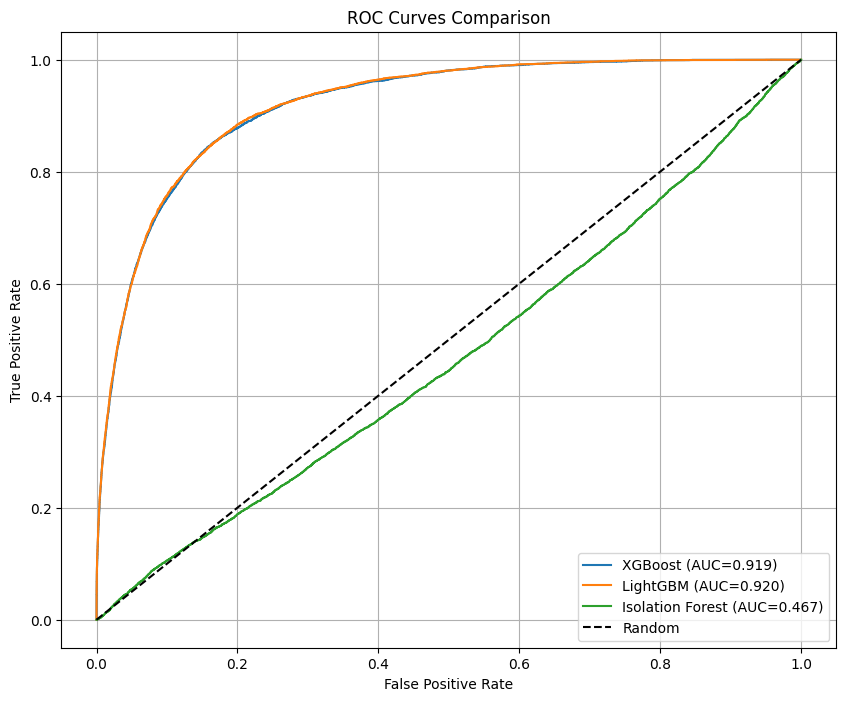


Best performing model: LightGBM (AUC: 0.9200)

Top 20 Most Important Features:
                    feature  importance
105                CRIFF_11         974
95        LATEST_RG3_TENURE         387
106                CRIFF_22         308
115      PRI_OVERDUE_ACCTS1         293
111            TOTAL_CRIFF1         265
123          LATEST_CR_DAYS         244
124          LATEST_DR_DAYS         206
112          DEC_CRIFFCHNG1         205
107                CRIFF_33         198
89                 POP_CODE         170
83             ALL_LON_OUTS         154
90                   NO_ENQ         150
88   OLDEST_RESIDUAL_TENURE         141
11       ONEMNTHOUTSTANGBAL         134
96               NO_YRS_RG3         128
114       PRI_ACTIVE_ACCTS1         128
103           LAST_1_YR_RG2         104
142       utilization_ratio          98
5                 INSTALAMT          93
119     PRIMARY_INSTAL_AMT1          91


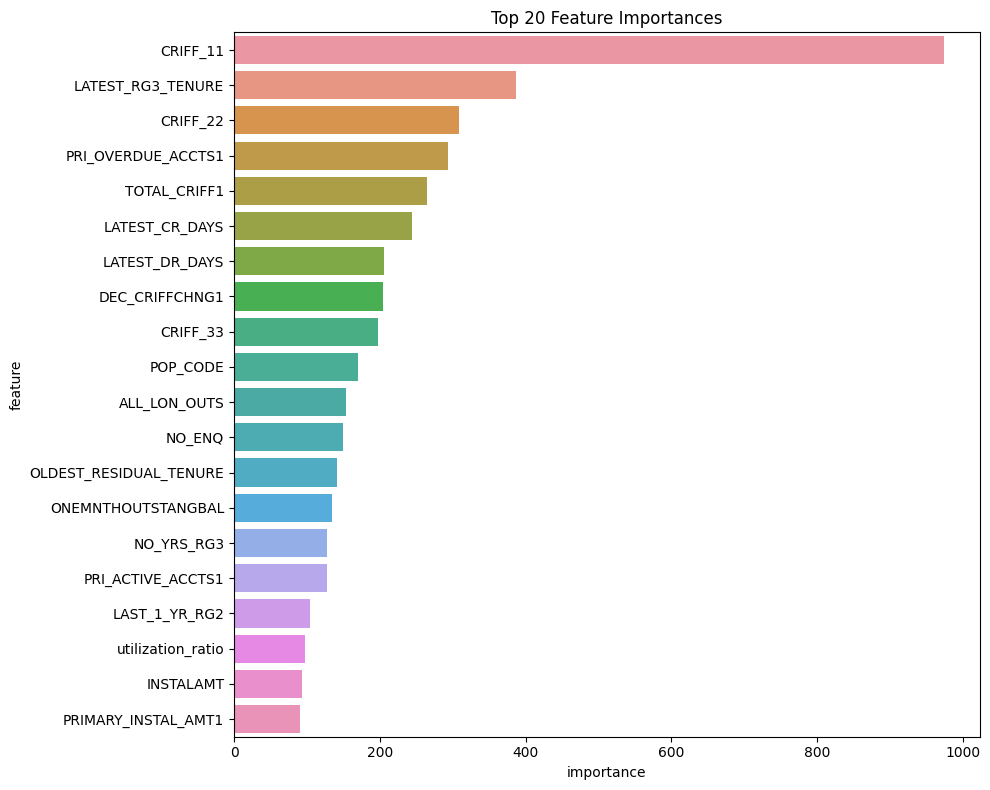

Generating SHAP explanations...


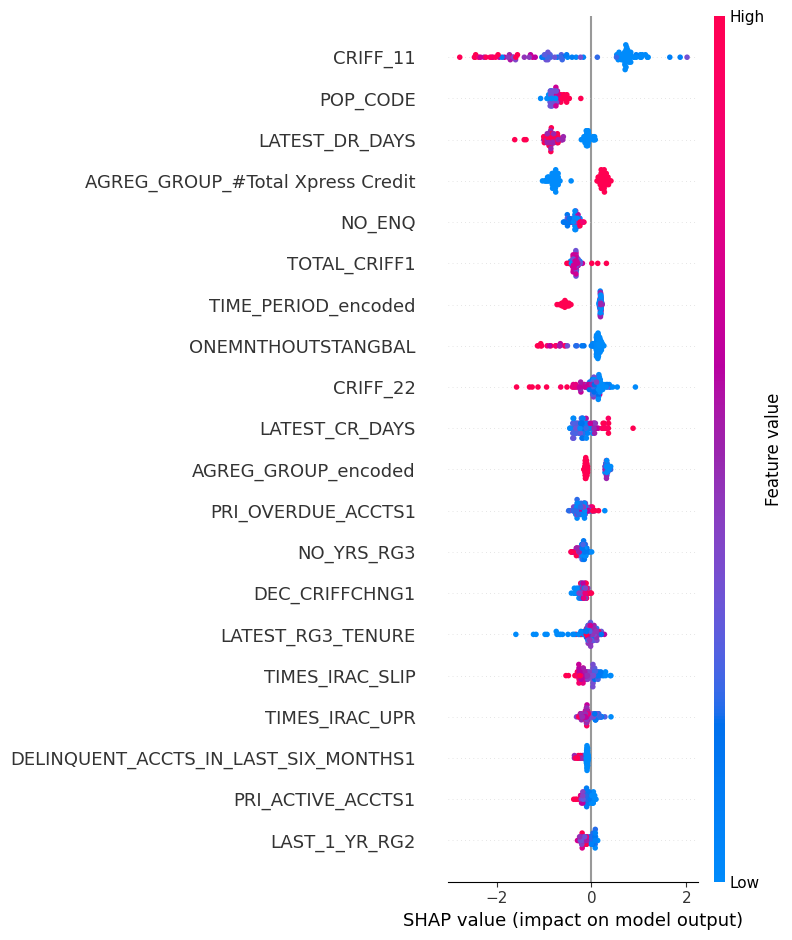


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     58461
           1       0.71      0.41      0.52      7088

    accuracy                           0.92     65549
   macro avg       0.82      0.70      0.74     65549
weighted avg       0.91      0.92      0.91     65549



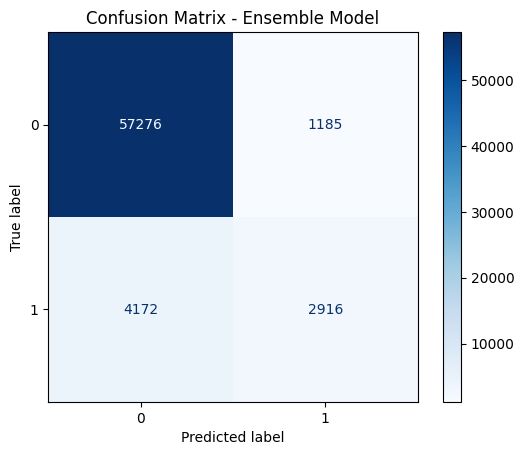


Ensemble Model Performance:
AUC: 0.9207
F1: 0.5212



===================== FRAUD DETECTION REPORT =====================
Total transactions analyzed: 65549
Actual fraud cases: 7088
Predicted fraud cases: 4101
High confidence fraud predictions (>0.7): 1310

High confidence fraud cases:
  Case 25: Probability = 0.728, Actual = 1
  Case 130: Probability = 0.787, Actual = 1
  Case 143: Probability = 0.809, Actual = 1
  Case 160: Probability = 0.757, Actual = 1
  Case 208: Probability = 0.891, Actual = 1
  Case 221: Probability = 0.815, Actual = 1
  Case 325: Probability = 0.770, Actual = 1
  Case 354: Probability = 0.730, Actual = 1
  Case 443: Probability = 0.733, Actual = 0
  Case 448: Probability = 0.741, Actual = 1


In [54]:
models, results, ensemble_pred, ensemble_proba = main_pipeline(df)

# Predicting for test dataset

In [55]:
df_test = pd.read_csv("/kaggle/input/psb-hackathon-2025/HACKATHON_PREDICTION_DATA.CSV")

In [56]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191693 entries, 0 to 191692
Columns: 138 entries, ACCT_AGE to UNIQUE_ID
dtypes: float64(120), int64(6), object(12)
memory usage: 201.8+ MB


In [57]:
print(f"\nMissing values:")
missing = df_test.isnull().sum()
print(missing[missing > 0])


Missing values:
ACCT_RESIDUAL_TENURE         2
KYC_SCR                    153
ONEMNTHCR                 9703
ONEMNTHSDR                9703
ONEMNTHOUTSTANGBAL        9703
                          ... 
AVERAGE_ACCT_AGE1         3532
CREDIT_HISTORY_LENGTH1    3532
NO_OF_INQUIRIES1          3532
INCOME_BAND1              3543
LATEST_CR_DAYS             847
Length: 113, dtype: int64


In [71]:
def predict_on_new_data(df_test, models, results):
    # Drop irrelevant columns
    #df_test_proc = df_test.drop(columns=['UNIQUE_ID', 'TIME_PERIOD'], errors='ignore')

    # Preprocess and feature engineer the test set
    df_test_proc = create_features(df_test)
    df_test_proc = preprocess_data(df_test_proc)
    df_test_proc = df_test_proc.drop(columns=['UNIQUE_ID', 'TIME_PERIOD'], errors='ignore')
    # Extract required features from the training pipeline
    required_cols = results[0]['model'].feature_names_in_

    # Check for missing columns
    missing_cols = set(required_cols) - set(df_test_proc.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns for prediction: {missing_cols}")

    # Ensure correct column order
    X_new = df_test_proc[required_cols]

    # Predict using ensemble
    proba_list = []
    for r in results:
        model = r['model']
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_new)[:, 1]
        else:
            proba = model.decision_function(X_new)
            proba = (proba - proba.min()) / (proba.max() - proba.min())  # Normalize
        proba_list.append(proba)

    # Weighted ensemble
    weights = [r['auc'] for r in results]
    total_weight = sum(weights)
    ensemble_proba = sum(w * p for w, p in zip(weights, proba_list)) / total_weight
    ensemble_pred = (ensemble_proba >= 0.5).astype(int)

    # Save predictions with UNIQUE_ID
    output_df = df_test[['UNIQUE_ID']].copy()
    output_df['PREDICTION'] = ensemble_pred
    output_df['PROBABILITY'] = ensemble_proba

    return output_df


In [72]:
output_df = predict_on_new_data(df_test, models, results)



=====================Creating new features=====================
Features created. New shape: (191693, 171)

=====================Preprocessing data with banking domain logic=====================
Found 158 numeric and 11 categorical columns
Processing categorical variables...
Processing categorical column: SI_FLG
  Unique values: 2
  Applied Label Encoding -> SI_FLG_encoded
Processing categorical column: LOCKER_HLDR_IND
  Unique values: 2
  Applied Label Encoding -> LOCKER_HLDR_IND_encoded
Processing categorical column: UID_FLG
  Unique values: 2
  Applied Label Encoding -> UID_FLG_encoded
Processing categorical column: KYC_FLG
  Unique values: 4
  Applied Label Encoding -> KYC_FLG_encoded
Processing categorical column: INB_FLG
  Unique values: 2
  Applied Label Encoding -> INB_FLG_encoded
Processing categorical column: EKYC_FLG
  Unique values: 2
  Applied Label Encoding -> EKYC_FLG_encoded
Processing categorical column: AVERAGE_ACCT_AGE1
  Filled 0 missing values with 'MISSING'
  Uni

In [73]:
print(output_df)

        UNIQUE_ID  PREDICTION  PROBABILITY
0            2202           0     0.205441
1            2209           0     0.219126
2            2211           0     0.216364
3            2217           0     0.220743
4            2218           0     0.203615
...           ...         ...          ...
191688     518266           0     0.200826
191689     518267           0     0.226510
191690     518269           0     0.195591
191691     518270           0     0.329007
191692     518271           0     0.215150

[191693 rows x 3 columns]


In [74]:
output_df.to_csv("/kaggle/working/predictions.csv", index=False)

### saved as predictions.csv